# 12 Reporting

In [20]:
from IPython.display import Image, display;

# I convert X_test to np.array and it causues the following warning when evaluating classifiers
import warnings
warnings.filterwarnings(
    "ignore",
    message="X does not have valid feature names",
    category=UserWarning
)

## Latex Table Export for Structured Only and Structured + Word2Vec Baseline Extended Tables (non-SMOTE)

In [24]:
# ============================================================
# Thesis Table Export — Extended Baseline (Non-SMOTE, 2025-11-08)
# Handles both structured-only and structured + Word2Vec
# ============================================================

import pandas as pd
from pathlib import Path
from src.utils import resolve_path

# ------------------------------------------------------------
# Paths
# ------------------------------------------------------------
base_eval_dir = resolve_path("results/evaluation/20251108")
baseline_orig_path = base_eval_dir / "original_baseline_extended_20251108_summary.csv"
baseline_w2v_path  = base_eval_dir / "w2v_radiology_baseline_extended_20251108_summary.csv"

output_dir = resolve_path("reports/tables")
output_dir.mkdir(parents=True, exist_ok=True)

table_orig_tex = output_dir / "baseline_structured_summary.tex"
table_w2v_tex  = output_dir / "baseline_multimodal_summary.tex"

# ------------------------------------------------------------
# Load data
# ------------------------------------------------------------
df_orig = pd.read_csv(baseline_orig_path)
df_w2v  = pd.read_csv(baseline_w2v_path)

# ------------------------------------------------------------
# Helper: prepare each dataframe
# ------------------------------------------------------------
def prepare_table(df):
    # Always keep Classifier, CV metrics, and test-set metrics
    keep_cols = ["Classifier", "CV_AUROC_mean", "CV_AUROC_std"] + [
        c for c in df.columns if c.endswith("_test")
    ]
    df = df[keep_cols].copy()

    # Rename columns
    rename_map = {
        "Classifier": "Model",
        "AUC_test": "AUROC",
        "CV_AUROC_mean": "Mean CV AUROC",
        "CV_AUROC_std": "SD CV AUROC",
        "AUPRC_test": "AUPRC",
        "Accuracy_test": "Accuracy",
        "BalancedAccuracy_test": "Balanced Accuracy",
        "Precision_test": "Precision",
        "Recall_test": "Recall",
        "F1_test": "F1",
        "F2_test": "F2",
        "Brier_test": "Brier Score",
        "ECE_test": "Expected Calibration Error",
        "MCC_test": "Matthews Corr.",
        "CalibrationSlope_test": "Calibration Slope",
        "CalibrationIntercept_test": "Calibration Intercept"
    }
    df.rename(columns={k: v for k, v in rename_map.items() if k in df.columns}, inplace=True)

    # Clean model names
    df["Model"] = df["Model"].replace({
        "LogisticRegression": "Logistic Regression",
        "NaiveBayes": "Naïve Bayes",
        "RandomForest": "Random Forest",
        "GradientBoosting": "Gradient Boosting",
        "XGB": "XGBoost",
        "LGBM": "LightGBM",
        "MLP": "Neural Network (MLP)",
        "SVC": "Support Vector Machine",
        "DecisionTree": "Decision Tree",
        "CatBoost": "CatBoost"
    })

    # Format numeric values
    for c in df.columns:
        if c != "Model":
            df[c] = df[c].map(lambda x: f"{x:.3f}" if pd.notna(x) else "")

    # Sort by AUROC if available
    if "AUROC" in df.columns:
        df = df.sort_values("AUROC", ascending=False, key=lambda s: s.astype(float))

    # Reorder columns: Model → AUROC → CV metrics → others
    col_order = ["Model", "AUROC", "Mean CV AUROC", "SD CV AUROC"]
    remaining = [c for c in df.columns if c not in col_order]
    df = df[[c for c in col_order if c in df.columns] + remaining]

    return df.reset_index(drop=True)

df_orig_fmt = prepare_table(df_orig)
df_w2v_fmt  = prepare_table(df_w2v)

# ------------------------------------------------------------
# Export helper
# ------------------------------------------------------------
def export_latex(df, path, caption, label):
    latex_str = df.to_latex(
        index=False,
        escape=False,
        caption=caption,
        label=label,
        column_format="l" + "c" * (df.shape[1] - 1)
    )
    latex_str = latex_str.replace("\\begin{table}", "\\begin{table}\n\\centering")
    latex_str = latex_str.replace("\\begin{tabular}", "\\resizebox{\\textwidth}{!}{\\begin{tabular}")
    latex_str = latex_str.replace("\\end{tabular}", "\\end{tabular}}")
    latex_str = (
        latex_str.replace("\\toprule", "\\hline")
                 .replace("\\midrule", "\\hline")
                 .replace("\\bottomrule", "\\hline")
    )

    with open(path, "w", encoding="utf-8") as f:
        f.write(latex_str)
    print(f"✅ Exported LaTeX table: {path}")

# ------------------------------------------------------------
# Export both tables
# ------------------------------------------------------------
export_latex(
    df_orig_fmt,
    table_orig_tex,
    caption="Structured-only baseline model performance (non-SMOTE).",
    label="tab:baseline_structured_summary"
)

export_latex(
    df_w2v_fmt,
    table_w2v_tex,
    caption="Structured + Word2Vec baseline model performance (non-SMOTE).",
    label="tab:baseline_multimodal_summary"
)

# ------------------------------------------------------------
# Preview
# ------------------------------------------------------------
print("\nStructured-only Baseline Models:")
display(df_orig_fmt.head())

print("\nStructured + Word2Vec Baseline Models:")
display(df_w2v_fmt.head())


✅ Exported LaTeX table: C:\Users\tyler\OneDrive - University of Pittsburgh\BIOST 2021 Thesis\Masters-Thesis\reports\tables\baseline_structured_summary.tex
✅ Exported LaTeX table: C:\Users\tyler\OneDrive - University of Pittsburgh\BIOST 2021 Thesis\Masters-Thesis\reports\tables\baseline_multimodal_summary.tex

Structured-only Baseline Models:


,Model,AUROC,Mean CV AUROC,SD CV AUROC,Brier Score,Accuracy,Precision,Recall,F1,F2
0,CatBoost,0.734,0.718,0.020,0.156,0.773,0.545,0.124,0.203,0.147
1,XGBoost,0.729,0.717,0.019,0.158,0.773,0.536,0.124,0.202,0.147
2,Gradient Boosting,0.727,0.717,0.020,0.158,0.773,0.551,0.112,0.186,0.133
3,Random Forest,0.726,0.720,0.021,0.159,0.778,0.917,0.046,0.087,0.056
4,LightGBM,0.726,0.706,0.017,0.160,0.766,0.483,0.174,0.256,0.200



Structured + Word2Vec Baseline Models:


,Model,AUROC,Mean CV AUROC,SD CV AUROC,Brier Score,Accuracy,Precision,Recall,F1,F2
0,CatBoost,0.757,0.744,0.018,0.153,0.775,0.561,0.133,0.215,0.157
1,Gradient Boosting,0.753,0.738,0.018,0.154,0.773,0.551,0.112,0.186,0.133
2,Logistic Regression,0.752,0.736,0.017,0.153,0.781,0.587,0.183,0.279,0.212
3,XGBoost,0.752,0.744,0.017,0.161,0.773,0.532,0.137,0.218,0.161
4,LightGBM,0.750,0.743,0.018,0.155,0.777,0.565,0.162,0.252,0.189


## Latex Table Export for Structured Only and Structured + Word2Vec Baseline Extended Tables (SMOTE)

In [25]:
# ============================================================
# Thesis Table Export — Extended Baseline (SMOTE, 2025-11-08)
# Handles both structured-only and structured + Word2Vec
# ============================================================

import pandas as pd
from pathlib import Path
from src.utils import resolve_path

# ------------------------------------------------------------
# Paths
# ------------------------------------------------------------
base_eval_dir = resolve_path("results/evaluation/20251108")
baseline_orig_path = base_eval_dir / "original_baseline_smote_extended_20251108_summary.csv"
baseline_w2v_path  = base_eval_dir / "w2v_radiology_baseline_smote_extended_20251108_summary.csv"

output_dir = resolve_path("reports/tables")
output_dir.mkdir(parents=True, exist_ok=True)

table_orig_tex = output_dir / "baseline_structured_smote_summary.tex"
table_w2v_tex  = output_dir / "baseline_multimodal_smote_summary.tex"

# ------------------------------------------------------------
# Load data
# ------------------------------------------------------------
df_orig_smote = pd.read_csv(baseline_orig_path)
df_w2v_smote  = pd.read_csv(baseline_w2v_path)

# ------------------------------------------------------------
# Helper: prepare each dataframe
# ------------------------------------------------------------
def prepare_table(df):
    # Always keep Classifier, CV metrics, and test-set metrics
    keep_cols = ["Classifier", "CV_AUROC_mean", "CV_AUROC_std"] + [
        c for c in df.columns if c.endswith("_test")
    ]
    df = df[keep_cols].copy()

    # Rename columns
    rename_map = {
        "Classifier": "Model",
        "AUC_test": "AUROC",
        "CV_AUROC_mean": "Mean CV AUROC",
        "CV_AUROC_std": "SD CV AUROC",
        "AUPRC_test": "AUPRC",
        "Accuracy_test": "Accuracy",
        "BalancedAccuracy_test": "Balanced Accuracy",
        "Precision_test": "Precision",
        "Recall_test": "Recall",
        "F1_test": "F1",
        "F2_test": "F2",
        "Brier_test": "Brier Score",
        "ECE_test": "Expected Calibration Error",
        "MCC_test": "Matthews Corr.",
        "CalibrationSlope_test": "Calibration Slope",
        "CalibrationIntercept_test": "Calibration Intercept"
    }
    df.rename(columns={k: v for k, v in rename_map.items() if k in df.columns}, inplace=True)

    # Clean model names
    df["Model"] = df["Model"].replace({
        "LogisticRegression": "Logistic Regression",
        "NaiveBayes": "Naïve Bayes",
        "RandomForest": "Random Forest",
        "GradientBoosting": "Gradient Boosting",
        "XGB": "XGBoost",
        "LGBM": "LightGBM",
        "MLP": "Neural Network (MLP)",
        "SVC": "Support Vector Machine",
        "DecisionTree": "Decision Tree",
        "CatBoost": "CatBoost"
    })

    # Format numeric values
    for c in df.columns:
        if c != "Model":
            df[c] = df[c].map(lambda x: f"{x:.3f}" if pd.notna(x) else "")

    # Sort by AUROC if available
    if "AUROC" in df.columns:
        df = df.sort_values("AUROC", ascending=False, key=lambda s: s.astype(float))

    # Reorder columns: Model → AUROC → CV metrics → others
    col_order = ["Model", "AUROC", "Mean CV AUROC", "SD CV AUROC"]
    remaining = [c for c in df.columns if c not in col_order]
    df = df[[c for c in col_order if c in df.columns] + remaining]

    return df.reset_index(drop=True)

df_orig_fmt_smote = prepare_table(df_orig_smote)
df_w2v_fmt_smote  = prepare_table(df_w2v_smote)

# ------------------------------------------------------------
# Export helper
# ------------------------------------------------------------
def export_latex(df, path, caption, label):
    latex_str = df.to_latex(
        index=False,
        escape=False,
        caption=caption,
        label=label,
        column_format="l" + "c" * (df.shape[1] - 1)
    )
    # Center and resize for full-width display
    latex_str = latex_str.replace("\\begin{table}", "\\begin{table}\n\\centering")
    latex_str = latex_str.replace("\\begin{tabular}", "\\resizebox{\\textwidth}{!}{\\begin{tabular}")
    latex_str = latex_str.replace("\\end{tabular}", "\\end{tabular}}")
    latex_str = (
        latex_str.replace("\\toprule", "\\hline")
                 .replace("\\midrule", "\\hline")
                 .replace("\\bottomrule", "\\hline")
    )

    with open(path, "w", encoding="utf-8") as f:
        f.write(latex_str)
    print(f"✅ Exported LaTeX table: {path}")

# ------------------------------------------------------------
# Export both tables
# ------------------------------------------------------------
export_latex(
    df_orig_fmt_smote,
    table_orig_tex,
    caption="Structured-only baseline model performance (SMOTE).",
    label="tab:baseline_structured_smote_summary"
)

export_latex(
    df_w2v_fmt_smote,
    table_w2v_tex,
    caption="Structured + Word2Vec baseline model performance (SMOTE).",
    label="tab:baseline_multimodal_smote_summary"
)

# ------------------------------------------------------------
# Preview
# ------------------------------------------------------------
print("\nStructured-only SMOTE Baseline Models:")
display(df_orig_fmt_smote.head())

print("\nStructured + Word2Vec SMOTE Baseline Models:")
display(df_w2v_fmt_smote.head())


✅ Exported LaTeX table: C:\Users\tyler\OneDrive - University of Pittsburgh\BIOST 2021 Thesis\Masters-Thesis\reports\tables\baseline_structured_smote_summary.tex
✅ Exported LaTeX table: C:\Users\tyler\OneDrive - University of Pittsburgh\BIOST 2021 Thesis\Masters-Thesis\reports\tables\baseline_multimodal_smote_summary.tex

Structured-only SMOTE Baseline Models:


,Model,AUROC,Mean CV AUROC,SD CV AUROC,Brier Score,Accuracy,Precision,Recall,F1,F2
0,CatBoost,0.725,0.908,0.009,0.167,0.748,0.434,0.299,0.354,0.319
1,Logistic Regression,0.716,0.724,0.016,0.222,0.640,0.357,0.697,0.473,0.586
2,XGBoost,0.713,0.911,0.008,0.176,0.726,0.406,0.403,0.404,0.403
3,LightGBM,0.710,0.929,0.005,0.168,0.757,0.462,0.299,0.363,0.321
4,Gradient Boosting,0.703,0.849,0.015,0.198,0.682,0.377,0.573,0.455,0.519



Structured + Word2Vec SMOTE Baseline Models:


,Model,AUROC,Mean CV AUROC,SD CV AUROC,Brier Score,Accuracy,Precision,Recall,F1,F2
0,Logistic Regression,0.748,0.779,0.013,0.206,0.665,0.374,0.664,0.478,0.575
1,XGBoost,0.742,0.953,0.005,0.164,0.763,0.475,0.232,0.312,0.259
2,CatBoost,0.741,0.941,0.008,0.159,0.759,0.465,0.274,0.345,0.298
3,LightGBM,0.737,0.946,0.006,0.161,0.758,0.455,0.232,0.308,0.258
4,Support Vector Machine,0.734,0.775,0.013,0.209,0.662,0.371,0.664,0.476,0.574


## Latex Table Export for Optimized Word2Vec Extended Tables (non-SMOTE)

In [26]:
# ============================================================
# Thesis Table Export — Optimized Word2Vec (Non-SMOTE, 2025-11-08)
# ============================================================

import pandas as pd
from pathlib import Path
from src.utils import resolve_path

# ------------------------------------------------------------
# Paths
# ------------------------------------------------------------
base_eval_dir = resolve_path("results/evaluation/20251108")
opt_w2v_path  = base_eval_dir / "w2v_optimized_extended_summary.csv"

output_dir = resolve_path("reports/tables")
output_dir.mkdir(parents=True, exist_ok=True)

table_w2v_opt_tex = output_dir / "opt_w2v_summary.tex"

# ------------------------------------------------------------
# Load data
# ------------------------------------------------------------
df_w2v_opt = pd.read_csv(opt_w2v_path)

# ------------------------------------------------------------
# Helper: prepare dataframe
# ------------------------------------------------------------
def prepare_table(df):
    keep_cols = ["Classifier", "CV_AUROC_mean", "CV_AUROC_std"] + [
        c for c in df.columns if c.endswith("_test")
    ]
    df = df[keep_cols].copy()

    rename_map = {
        "Classifier": "Model",
        "AUC_test": "AUROC",
        "CV_AUROC_mean": "Mean CV AUROC",
        "CV_AUROC_std": "SD CV AUROC",
        "AUPRC_test": "AUPRC",
        "Accuracy_test": "Accuracy",
        "BalancedAccuracy_test": "Balanced Accuracy",
        "Precision_test": "Precision",
        "Recall_test": "Recall",
        "F1_test": "F1",
        "F2_test": "F2",
        "Brier_test": "Brier Score",
        "ECE_test": "Expected Calibration Error",
        "MCC_test": "Matthews Corr.",
        "CalibrationSlope_test": "Calibration Slope",
        "CalibrationIntercept_test": "Calibration Intercept"
    }
    df.rename(columns={k: v for k, v in rename_map.items() if k in df.columns}, inplace=True)

    df["Model"] = df["Model"].replace({
        "LogisticRegression": "Logistic Regression",
        "NaiveBayes": "Naïve Bayes",
        "RandomForest": "Random Forest",
        "GradientBoosting": "Gradient Boosting",
        "XGB": "XGBoost",
        "LGBM": "LightGBM",
        "MLP": "Neural Network (MLP)",
        "SVC": "Support Vector Machine",
        "DecisionTree": "Decision Tree",
        "CatBoost": "CatBoost"
    })

    for c in df.columns:
        if c != "Model":
            df[c] = df[c].map(lambda x: f"{x:.3f}" if pd.notna(x) else "")

    if "AUROC" in df.columns:
        df = df.sort_values("AUROC", ascending=False, key=lambda s: s.astype(float))

    col_order = ["Model", "AUROC", "Mean CV AUROC", "SD CV AUROC"]
    remaining = [c for c in df.columns if c not in col_order]
    df = df[[c for c in col_order if c in df.columns] + remaining]

    return df.reset_index(drop=True)

df_w2v_opt_fmt = prepare_table(df_w2v_opt)

# ------------------------------------------------------------
# Export helper
# ------------------------------------------------------------
def export_latex(df, path, caption, label):
    latex_str = df.to_latex(
        index=False,
        escape=False,
        caption=caption,
        label=label,
        column_format="l" + "c" * (df.shape[1] - 1)
    )
    latex_str = latex_str.replace("\\begin{table}", "\\begin{table}\n\\centering")
    latex_str = latex_str.replace("\\begin{tabular}", "\\resizebox{\\textwidth}{!}{\\begin{tabular}")
    latex_str = latex_str.replace("\\end{tabular}", "\\end{tabular}}")
    latex_str = (
        latex_str.replace("\\toprule", "\\hline")
                 .replace("\\midrule", "\\hline")
                 .replace("\\bottomrule", "\\hline")
    )

    with open(path, "w", encoding="utf-8") as f:
        f.write(latex_str)
    print(f"✅ Exported LaTeX table: {path}")

# ------------------------------------------------------------
# Export table
# ------------------------------------------------------------
export_latex(
    df_w2v_opt_fmt,
    table_w2v_opt_tex,
    caption="Optimized Word2Vec multimodal model performance (non-SMOTE).",
    label="tab:opt_w2v_summary"
)

print("\nOptimized Word2Vec Models (Non-SMOTE):")
display(df_w2v_opt_fmt.head())


✅ Exported LaTeX table: C:\Users\tyler\OneDrive - University of Pittsburgh\BIOST 2021 Thesis\Masters-Thesis\reports\tables\opt_w2v_summary.tex

Optimized Word2Vec Models (Non-SMOTE):


,Model,AUROC,Mean CV AUROC,SD CV AUROC,Brier Score,Accuracy,Precision,Recall,F1,F2
0,Logistic Regression,0.757,0.745,0.018,0.153,0.776,0.550,0.183,0.274,0.211
1,CatBoost,0.756,0.748,0.018,0.154,0.783,0.703,0.108,0.187,0.130
2,Gradient Boosting,0.752,0.746,0.019,0.154,0.775,0.549,0.162,0.250,0.188
3,XGBoost,0.751,0.748,0.018,0.161,0.776,0.561,0.153,0.241,0.180
4,LightGBM,0.743,0.745,0.019,0.157,0.777,0.557,0.183,0.275,0.211


## Latex Table Export for Optimized Word2Vec Extended Tables (SMOTE)

In [27]:
# ============================================================
# Thesis Table Export — Optimized Word2Vec (SMOTE, 2025-11-08)
# ============================================================

import pandas as pd
from pathlib import Path
from src.utils import resolve_path

# ------------------------------------------------------------
# Paths
# ------------------------------------------------------------
base_eval_dir = resolve_path("results/evaluation/20251108")
opt_w2v_smote_path = base_eval_dir / "w2v_optimized_extended_summary_smote.csv"

output_dir = resolve_path("reports/tables")
output_dir.mkdir(parents=True, exist_ok=True)

table_w2v_opt_smote_tex = output_dir / "opt_w2v_smote_summary.tex"

# ------------------------------------------------------------
# Load and prepare data
# ------------------------------------------------------------
df_w2v_opt_smote = pd.read_csv(opt_w2v_smote_path)

def prepare_table(df):
    keep_cols = ["Classifier", "CV_AUROC_mean", "CV_AUROC_std"] + [
        c for c in df.columns if c.endswith("_test")
    ]
    df = df[keep_cols].copy()

    rename_map = {
        "Classifier": "Model",
        "AUC_test": "AUROC",
        "CV_AUROC_mean": "Mean CV AUROC",
        "CV_AUROC_std": "SD CV AUROC",
        "AUPRC_test": "AUPRC",
        "Accuracy_test": "Accuracy",
        "BalancedAccuracy_test": "Balanced Accuracy",
        "Precision_test": "Precision",
        "Recall_test": "Recall",
        "F1_test": "F1",
        "F2_test": "F2",
        "Brier_test": "Brier Score",
        "ECE_test": "Expected Calibration Error",
        "MCC_test": "Matthews Corr.",
        "CalibrationSlope_test": "Calibration Slope",
        "CalibrationIntercept_test": "Calibration Intercept"
    }
    df.rename(columns={k: v for k, v in rename_map.items() if k in df.columns}, inplace=True)

    df["Model"] = df["Model"].replace({
        "LogisticRegression": "Logistic Regression",
        "NaiveBayes": "Naïve Bayes",
        "RandomForest": "Random Forest",
        "GradientBoosting": "Gradient Boosting",
        "XGB": "XGBoost",
        "LGBM": "LightGBM",
        "MLP": "Neural Network (MLP)",
        "SVC": "Support Vector Machine",
        "DecisionTree": "Decision Tree",
        "CatBoost": "CatBoost"
    })

    for c in df.columns:
        if c != "Model":
            df[c] = df[c].map(lambda x: f"{x:.3f}" if pd.notna(x) else "")

    if "AUROC" in df.columns:
        df = df.sort_values("AUROC", ascending=False, key=lambda s: s.astype(float))

    col_order = ["Model", "AUROC", "Mean CV AUROC", "SD CV AUROC"]
    remaining = [c for c in df.columns if c not in col_order]
    df = df[[c for c in col_order if c in df.columns] + remaining]

    return df.reset_index(drop=True)

df_w2v_opt_smote_fmt = prepare_table(df_w2v_opt_smote)

# ------------------------------------------------------------
# Export LaTeX
# ------------------------------------------------------------
def export_latex(df, path, caption, label):
    latex_str = df.to_latex(
        index=False,
        escape=False,
        caption=caption,
        label=label,
        column_format="l" + "c" * (df.shape[1] - 1)
    )
    latex_str = latex_str.replace("\\begin{table}", "\\begin{table}\n\\centering")
    latex_str = latex_str.replace("\\begin{tabular}", "\\resizebox{\\textwidth}{!}{\\begin{tabular}")
    latex_str = latex_str.replace("\\end{tabular}", "\\end{tabular}}")
    latex_str = (
        latex_str.replace("\\toprule", "\\hline")
                 .replace("\\midrule", "\\hline")
                 .replace("\\bottomrule", "\\hline")
    )

    with open(path, "w", encoding="utf-8") as f:
        f.write(latex_str)
    print(f"✅ Exported LaTeX table: {path}")

export_latex(
    df_w2v_opt_smote_fmt,
    table_w2v_opt_smote_tex,
    caption="Optimized Word2Vec multimodal model performance (SMOTE).",
    label="tab:opt_w2v_smote_summary"
)

print("\nOptimized Word2Vec Models (SMOTE):")
display(df_w2v_opt_smote_fmt.head())


✅ Exported LaTeX table: C:\Users\tyler\OneDrive - University of Pittsburgh\BIOST 2021 Thesis\Masters-Thesis\reports\tables\opt_w2v_smote_summary.tex

Optimized Word2Vec Models (SMOTE):


,Model,AUROC,Mean CV AUROC,SD CV AUROC,Brier Score,Accuracy,Precision,Recall,F1,F2
0,Logistic Regression,0.753,0.779,0.011,0.203,0.681,0.393,0.697,0.503,0.604
1,XGBoost,0.752,0.945,0.008,0.161,0.771,0.510,0.220,0.307,0.248
2,LightGBM,0.751,0.939,0.007,0.156,0.781,0.555,0.274,0.367,0.305
3,Random Forest,0.737,0.948,0.008,0.164,0.778,0.547,0.241,0.334,0.271
4,CatBoost,0.736,0.945,0.006,0.157,0.779,0.551,0.245,0.339,0.275


## Δ(W2V – Structured) Baseline Comparison Tables

In [30]:
# ============================================================
# Thesis Table Export — Δ(W2V – Structured) Comparison Tables
# non-SMOTE and SMOTE
# ============================================================

import pandas as pd
from pathlib import Path
from src.utils import resolve_path

# ------------------------------------------------------------
# Helpers
# ------------------------------------------------------------
def convert_numeric(df):
    df = df.copy()
    for c in df.columns:
        if c != "Model":
            df[c] = pd.to_numeric(
                df[c].astype(str)
                .str.replace("±", "")
                .str.replace("−", "-")
                .str.strip(),
                errors="coerce"
            )
    return df

def format_floats(df):
    """Round to 3 decimals and remove trailing zeros/periods."""
    for c in df.columns:
        if c != "Model":
            df[c] = df[c].apply(
                lambda x: f"{x:.3f}".rstrip("0").rstrip(".") if pd.notna(x) else ""
            )
    return df

def compute_delta(df_orig, df_w2v):
    """Compute Δ(W2V – Structured) and sort by ΔAUROC."""
    common_models = set(df_orig["Model"]).intersection(df_w2v["Model"])
    df_orig = df_orig[df_orig["Model"].isin(common_models)].copy()
    df_w2v  = df_w2v[df_w2v["Model"].isin(common_models)].copy()

    df_orig = convert_numeric(df_orig).set_index("Model").sort_index()
    df_w2v  = convert_numeric(df_w2v).set_index("Model").sort_index()

    delta = df_w2v - df_orig
    delta.insert(0, "Model", delta.index)
    delta.columns = [f"$\\Delta${c}" if c != "Model" else "Model" for c in delta.columns]

    # Round and clean
    delta = delta.round(3)
    delta = format_floats(delta)

    # Sort by ΔAUROC descending if present
    if "$\\Delta$AUROC" in delta.columns:
        delta["sort_key"] = pd.to_numeric(delta["$\\Delta$AUROC"], errors="coerce")
        delta = delta.sort_values("sort_key", ascending=False).drop(columns="sort_key")

    return delta.reset_index(drop=True)

# ------------------------------------------------------------
# Load formatted dataframes (from earlier)
# ------------------------------------------------------------
df_orig_fmt_non = df_orig_fmt.copy()
df_w2v_fmt_non  = df_w2v_fmt.copy()

df_orig_fmt_smote = df_orig_fmt_smote.copy() if 'df_orig_fmt_smote' in locals() else None
df_w2v_fmt_smote  = df_w2v_fmt_smote.copy() if 'df_w2v_fmt_smote' in locals() else None

# ------------------------------------------------------------
# Compute deltas
# ------------------------------------------------------------
delta_non = compute_delta(df_orig_fmt_non, df_w2v_fmt_non)
if df_orig_fmt_smote is not None and df_w2v_fmt_smote is not None:
    delta_smote = compute_delta(df_orig_fmt_smote, df_w2v_fmt_smote)
else:
    delta_smote = None

# ------------------------------------------------------------
# Export helper
# ------------------------------------------------------------
def export_latex(df, path, caption, label):
    latex_str = df.to_latex(
        index=False,
        escape=False,
        caption=caption,
        label=label,
        column_format="l" + "c" * (df.shape[1] - 1)
    )
    latex_str = latex_str.replace("\\begin{table}", "\\begin{table}\n\\centering")
    latex_str = latex_str.replace("\\begin{tabular}", "\\resizebox{\\textwidth}{!}{\\begin{tabular}")
    latex_str = latex_str.replace("\\end{tabular}", "\\end{tabular}}")
    latex_str = (
        latex_str.replace("\\toprule", "\\hline")
                 .replace("\\midrule", "\\hline")
                 .replace("\\bottomrule", "\\hline")
    )
    with open(path, "w", encoding="utf-8") as f:
        f.write(latex_str)
    print(f"✅ Exported LaTeX table: {path}")

# ------------------------------------------------------------
# Output paths
# ------------------------------------------------------------
output_dir = resolve_path("reports/tables")
output_dir.mkdir(parents=True, exist_ok=True)

table_delta_non_path = output_dir / "baseline_comparison_delta.tex"
table_delta_smote_path = output_dir / "baseline_comparison_smote_delta.tex"

# ------------------------------------------------------------
# Export both Δ tables
# ------------------------------------------------------------
export_latex(
    delta_non,
    table_delta_non_path,
    caption="Performance improvement ($\\Delta$) between structured-only and structured + Word2Vec baseline models (non-SMOTE), ordered by $\\Delta$AUROC.",
    label="tab:baseline_comparison_delta"
)

if delta_smote is not None:
    export_latex(
        delta_smote,
        table_delta_smote_path,
        caption="Performance improvement ($\\Delta$) between structured-only and structured + Word2Vec baseline models (SMOTE), ordered by $\\Delta$AUROC.",
        label="tab:baseline_comparison_smote_delta"
    )

# ------------------------------------------------------------
# Preview
# ------------------------------------------------------------
print("\nΔ Non-SMOTE Comparison (ordered by ΔAUROC, 3 decimals, trimmed):")
display(delta_non.head())

if delta_smote is not None:
    print("\nΔ SMOTE Comparison (ordered by ΔAUROC, 3 decimals, trimmed):")
    display(delta_smote.head())


✅ Exported LaTeX table: C:\Users\tyler\OneDrive - University of Pittsburgh\BIOST 2021 Thesis\Masters-Thesis\reports\tables\baseline_comparison_delta.tex
✅ Exported LaTeX table: C:\Users\tyler\OneDrive - University of Pittsburgh\BIOST 2021 Thesis\Masters-Thesis\reports\tables\baseline_comparison_smote_delta.tex

Δ Non-SMOTE Comparison (ordered by ΔAUROC, 3 decimals, trimmed):


,Model,$\Delta$AUROC,$\Delta$Mean CV AUROC,$\Delta$SD CV AUROC,$\Delta$Brier Score,$\Delta$Accuracy,$\Delta$Precision,$\Delta$Recall,$\Delta$F1,$\Delta$F2
0,Support Vector Machine,0.043,0.047,-0.002,-0.007,-0.001,-0.015,0,-0.001,0
1,Neural Network (MLP),0.04,0.044,0.004,-0.007,0.012,0.09,0.083,0.107,0.092
2,Logistic Regression,0.029,0.03,-0.001,-0.007,0.014,0.104,0.063,0.086,0.07
3,Gradient Boosting,0.026,0.021,-0.002,-0.004,0,0,0,0,0
4,LightGBM,0.024,0.037,0.001,-0.005,0.011,0.082,-0.012,-0.004,-0.011



Δ SMOTE Comparison (ordered by ΔAUROC, 3 decimals, trimmed):


,Model,$\Delta$AUROC,$\Delta$Mean CV AUROC,$\Delta$SD CV AUROC,$\Delta$Brier Score,$\Delta$Accuracy,$\Delta$Precision,$\Delta$Recall,$\Delta$F1,$\Delta$F2
0,Support Vector Machine,0.047,-0.093,0.001,0.005,-0.031,0.003,0.208,0.069,0.139
1,Neural Network (MLP),0.036,0.094,-0.032,-0.001,0.052,0.047,-0.095,-0.011,-0.057
2,Logistic Regression,0.032,0.055,-0.003,-0.016,0.025,0.017,-0.033,0.005,-0.011
3,XGBoost,0.029,0.042,-0.003,-0.012,0.037,0.069,-0.171,-0.092,-0.144
4,LightGBM,0.027,0.017,0.001,-0.007,0.001,-0.007,-0.067,-0.055,-0.063


## Δ(W2V Optimized – Structured) Comparison Tables

In [31]:
# ============================================================
# Thesis Table Export — Δ(Optimized W2V – Structured Baseline)
# Non-SMOTE and SMOTE
# ============================================================

import pandas as pd
from pathlib import Path
from src.utils import resolve_path

# ------------------------------------------------------------
# Helpers
# ------------------------------------------------------------
def convert_numeric(df):
    df = df.copy()
    for c in df.columns:
        if c != "Model":
            df[c] = pd.to_numeric(
                df[c].astype(str)
                .str.replace("±", "")
                .str.replace("−", "-")
                .str.strip(),
                errors="coerce"
            )
    return df

def format_floats(df):
    """Round to 3 decimals and remove trailing zeros/periods."""
    for c in df.columns:
        if c != "Model":
            df[c] = df[c].apply(
                lambda x: f"{x:.3f}".rstrip("0").rstrip(".") if pd.notna(x) else ""
            )
    return df

def compute_delta(df_structured, df_optimized):
    """Compute Δ(Optimized W2V – Structured Baseline) and sort by ΔAUROC."""
    common_models = set(df_structured["Model"]).intersection(df_optimized["Model"])
    df_structured = df_structured[df_structured["Model"].isin(common_models)].copy()
    df_optimized = df_optimized[df_optimized["Model"].isin(common_models)].copy()

    df_structured = convert_numeric(df_structured).set_index("Model").sort_index()
    df_optimized = convert_numeric(df_optimized).set_index("Model").sort_index()

    delta = df_optimized - df_structured
    delta.insert(0, "Model", delta.index)
    delta.columns = [f"$\\Delta${c}" if c != "Model" else "Model" for c in delta.columns]

    delta = delta.round(3)
    delta = format_floats(delta)

    if "$\\Delta$AUROC" in delta.columns:
        delta["sort_key"] = pd.to_numeric(delta["$\\Delta$AUROC"], errors="coerce")
        delta = delta.sort_values("sort_key", ascending=False).drop(columns="sort_key")

    return delta.reset_index(drop=True)

# ------------------------------------------------------------
# Load formatted dataframes (already prepared earlier)
# ------------------------------------------------------------
df_orig_fmt_non = df_orig_fmt.copy()              # structured-only (non-SMOTE)
df_w2v_opt_fmt = df_w2v_opt_fmt.copy()            # optimized W2V (non-SMOTE)

df_orig_fmt_smote = df_orig_fmt_smote.copy() if 'df_orig_fmt_smote' in locals() else None
df_w2v_opt_fmt_smote = df_w2v_opt_smote_fmt.copy() if 'df_w2v_opt_smote_fmt' in locals() else None

# ------------------------------------------------------------
# Compute deltas
# ------------------------------------------------------------
delta_non = compute_delta(df_orig_fmt_non, df_w2v_opt_fmt)
if df_orig_fmt_smote is not None and df_w2v_opt_fmt_smote is not None:
    delta_smote = compute_delta(df_orig_fmt_smote, df_w2v_opt_fmt_smote)
else:
    delta_smote = None

# ------------------------------------------------------------
# Export helper
# ------------------------------------------------------------
def export_latex(df, path, caption, label):
    latex_str = df.to_latex(
        index=False,
        escape=False,
        caption=caption,
        label=label,
        column_format="l" + "c" * (df.shape[1] - 1)
    )
    latex_str = latex_str.replace("\\begin{table}", "\\begin{table}\n\\centering")
    latex_str = latex_str.replace("\\begin{tabular}", "\\resizebox{\\textwidth}{!}{\\begin{tabular}")
    latex_str = latex_str.replace("\\end{tabular}", "\\end{tabular}}")
    latex_str = (
        latex_str.replace("\\toprule", "\\hline")
                 .replace("\\midrule", "\\hline")
                 .replace("\\bottomrule", "\\hline")
    )
    with open(path, "w", encoding="utf-8") as f:
        f.write(latex_str)
    print(f"✅ Exported LaTeX table: {path}")

# ------------------------------------------------------------
# Output paths
# ------------------------------------------------------------
output_dir = resolve_path("reports/tables")
output_dir.mkdir(parents=True, exist_ok=True)

table_delta_non_path = output_dir / "opt_w2v_comparison_delta.tex"
table_delta_smote_path = output_dir / "opt_w2v_comparison_smote_delta.tex"

# ------------------------------------------------------------
# Export both Δ tables
# ------------------------------------------------------------
export_latex(
    delta_non,
    table_delta_non_path,
    caption="Performance improvement ($\\Delta$) between structured-only and optimized Word2Vec multimodal models (non-SMOTE), ordered by $\\Delta$AUROC.",
    label="tab:opt_w2v_comparison_delta"
)

if delta_smote is not None:
    export_latex(
        delta_smote,
        table_delta_smote_path,
        caption="Performance improvement ($\\Delta$) between structured-only and optimized Word2Vec multimodal models (SMOTE), ordered by $\\Delta$AUROC.",
        label="tab:opt_w2v_comparison_smote_delta"
    )

# ------------------------------------------------------------
# Preview
# ------------------------------------------------------------
print("\nΔ Optimized W2V vs Structured Baseline (Non-SMOTE):")
display(delta_non.head())

if delta_smote is not None:
    print("\nΔ Optimized W2V vs Structured Baseline (SMOTE):")
    display(delta_smote.head())


✅ Exported LaTeX table: C:\Users\tyler\OneDrive - University of Pittsburgh\BIOST 2021 Thesis\Masters-Thesis\reports\tables\opt_w2v_comparison_delta.tex
✅ Exported LaTeX table: C:\Users\tyler\OneDrive - University of Pittsburgh\BIOST 2021 Thesis\Masters-Thesis\reports\tables\opt_w2v_comparison_smote_delta.tex

Δ Optimized W2V vs Structured Baseline (Non-SMOTE):


,Model,$\Delta$AUROC,$\Delta$Mean CV AUROC,$\Delta$SD CV AUROC,$\Delta$Brier Score,$\Delta$Accuracy,$\Delta$Precision,$\Delta$Recall,$\Delta$F1,$\Delta$F2
0,Logistic Regression,0.034,0.039,0,-0.007,0.009,0.067,0.063,0.081,0.069
1,Gradient Boosting,0.025,0.029,-0.001,-0.004,0.002,-0.002,0.05,0.064,0.055
2,CatBoost,0.022,0.03,-0.002,-0.002,0.01,0.158,-0.016,-0.016,-0.017
3,XGBoost,0.022,0.031,-0.001,0.003,0.003,0.025,0.029,0.039,0.033
4,LightGBM,0.017,0.039,0.002,-0.003,0.011,0.074,0.009,0.019,0.011



Δ Optimized W2V vs Structured Baseline (SMOTE):


,Model,$\Delta$AUROC,$\Delta$Mean CV AUROC,$\Delta$SD CV AUROC,$\Delta$Brier Score,$\Delta$Accuracy,$\Delta$Precision,$\Delta$Recall,$\Delta$F1,$\Delta$F2
0,LightGBM,0.041,0.01,0.002,-0.012,0.024,0.093,-0.025,0.004,-0.016
1,XGBoost,0.039,0.034,0,-0.015,0.045,0.104,-0.183,-0.097,-0.155
2,Logistic Regression,0.037,0.055,-0.005,-0.019,0.041,0.036,0,0.03,0.018
3,Random Forest,0.035,0.058,-0.005,-0.029,0.078,0.162,-0.257,-0.1,-0.199
4,Gradient Boosting,0.031,0.086,-0.007,-0.037,0.075,0.083,-0.287,-0.102,-0.209


## Δ(W2V Optimized – W2V Baseline) Comparison Tables

In [34]:
# ============================================================
# Thesis Table Export — Δ(Optimized W2V – Baseline W2V)
# Non-SMOTE and SMOTE
# ============================================================

import pandas as pd
from pathlib import Path
from src.utils import resolve_path

# ------------------------------------------------------------
# Helpers
# ------------------------------------------------------------
def convert_numeric(df):
    df = df.copy()
    for c in df.columns:
        if c != "Model":
            df[c] = pd.to_numeric(
                df[c].astype(str)
                .str.replace("±", "")
                .str.replace("−", "-")
                .str.strip(),
                errors="coerce"
            )
    return df

def format_floats(df):
    """Round to 3 decimals and remove trailing zeros/periods."""
    for c in df.columns:
        if c != "Model":
            df[c] = df[c].apply(
                lambda x: f"{x:.3f}".rstrip("0").rstrip(".") if pd.notna(x) else ""
            )
    return df

def compute_delta(df_baseline, df_optimized):
    """Compute Δ(Optimized – Baseline W2V) and sort by ΔAUROC."""
    common_models = set(df_baseline["Model"]).intersection(df_optimized["Model"])
    df_baseline = df_baseline[df_baseline["Model"].isin(common_models)].copy()
    df_optimized = df_optimized[df_optimized["Model"].isin(common_models)].copy()

    df_baseline = convert_numeric(df_baseline).set_index("Model").sort_index()
    df_optimized = convert_numeric(df_optimized).set_index("Model").sort_index()

    delta = df_optimized - df_baseline
    delta.insert(0, "Model", delta.index)
    delta.columns = [f"$\\Delta${c}" if c != "Model" else "Model" for c in delta.columns]

    # Round and clean
    delta = delta.round(3)
    delta = format_floats(delta)

    # Sort by ΔAUROC descending if present
    if "$\\Delta$AUROC" in delta.columns:
        delta["sort_key"] = pd.to_numeric(delta["$\\Delta$AUROC"], errors="coerce")
        delta = delta.sort_values("sort_key", ascending=False).drop(columns="sort_key")

    return delta.reset_index(drop=True)

# ------------------------------------------------------------
# Load formatted dataframes
# ------------------------------------------------------------
df_w2v_fmt_non = df_w2v_fmt.copy()               # baseline W2V (non-SMOTE)
df_w2v_opt_fmt = df_w2v_opt_fmt.copy()           # optimized W2V (non-SMOTE)

df_w2v_fmt_smote = df_w2v_fmt_smote.copy() if 'df_w2v_fmt_smote' in locals() else None
df_w2v_opt_fmt_smote = df_w2v_opt_smote_fmt.copy() if 'df_w2v_opt_smote_fmt' in locals() else None

# ------------------------------------------------------------
# Compute deltas
# ------------------------------------------------------------
delta_non = compute_delta(df_w2v_fmt_non, df_w2v_opt_fmt)
if df_w2v_fmt_smote is not None and df_w2v_opt_fmt_smote is not None:
    delta_smote = compute_delta(df_w2v_fmt_smote, df_w2v_opt_fmt_smote)
else:
    delta_smote = None

# ------------------------------------------------------------
# Export helper
# ------------------------------------------------------------
def export_latex(df, path, caption, label):
    latex_str = df.to_latex(
        index=False,
        escape=False,
        caption=caption,
        label=label,
        column_format="l" + "c" * (df.shape[1] - 1)
    )
    latex_str = latex_str.replace("\\begin{table}", "\\begin{table}\n\\centering")
    latex_str = latex_str.replace("\\begin{tabular}", "\\resizebox{\\textwidth}{!}{\\begin{tabular}")
    latex_str = latex_str.replace("\\end{tabular}", "\\end{tabular}}")
    latex_str = (
        latex_str.replace("\\toprule", "\\hline")
                 .replace("\\midrule", "\\hline")
                 .replace("\\bottomrule", "\\hline")
    )
    with open(path, "w", encoding="utf-8") as f:
        f.write(latex_str)
    print(f"✅ Exported LaTeX table: {path}")

# ------------------------------------------------------------
# Output paths (renamed)
# ------------------------------------------------------------
output_dir = resolve_path("reports/tables")
output_dir.mkdir(parents=True, exist_ok=True)

table_delta_non_path   = output_dir / "opt_w2v_vs_baseline_w2v_delta.tex"
table_delta_smote_path = output_dir / "opt_w2v_vs_baseline_w2v_smote_delta.tex"

# ------------------------------------------------------------
# Export both Δ tables
# ------------------------------------------------------------
export_latex(
    delta_non,
    table_delta_non_path,
    caption="Performance improvement ($\\Delta$) between baseline Word2Vec and optimized Word2Vec multimodal models (non-SMOTE), ordered by $\\Delta$AUROC.",
    label="tab:opt_w2v_vs_baseline_w2v_delta"
)

if delta_smote is not None:
    export_latex(
        delta_smote,
        table_delta_smote_path,
        caption="Performance improvement ($\\Delta$) between baseline Word2Vec and optimized Word2Vec multimodal models (SMOTE), ordered by $\\Delta$AUROC.",
        label="tab:opt_w2v_vs_baseline_w2v_smote_delta"
    )

# ------------------------------------------------------------
# Preview
# ------------------------------------------------------------
print("\nΔ Optimized vs Baseline W2V (Non-SMOTE):")
display(delta_non.head())

if delta_smote is not None:
    print("\nΔ Optimized vs Baseline W2V (SMOTE):")
    display(delta_smote.head())


✅ Exported LaTeX table: C:\Users\tyler\OneDrive - University of Pittsburgh\BIOST 2021 Thesis\Masters-Thesis\reports\tables\opt_w2v_vs_baseline_w2v_delta.tex
✅ Exported LaTeX table: C:\Users\tyler\OneDrive - University of Pittsburgh\BIOST 2021 Thesis\Masters-Thesis\reports\tables\opt_w2v_vs_baseline_w2v_smote_delta.tex

Δ Optimized vs Baseline W2V (Non-SMOTE):


,Model,$\Delta$AUROC,$\Delta$Mean CV AUROC,$\Delta$SD CV AUROC,$\Delta$Brier Score,$\Delta$Accuracy,$\Delta$Precision,$\Delta$Recall,$\Delta$F1,$\Delta$F2
0,Logistic Regression,0.005,0.009,0.001,0,-0.005,-0.037,0,-0.005,-0.001
1,Random Forest,0.003,0.005,0.001,-0.001,0.003,0.034,0.013,0.023,0.015
2,CatBoost,-0.001,0.004,0,0.001,0.008,0.142,-0.025,-0.028,-0.027
3,Gradient Boosting,-0.001,0.008,0.001,0,0.002,-0.002,0.05,0.064,0.055
4,XGBoost,-0.001,0.004,0.001,0,0.003,0.029,0.016,0.023,0.019



Δ Optimized vs Baseline W2V (SMOTE):


,Model,$\Delta$AUROC,$\Delta$Mean CV AUROC,$\Delta$SD CV AUROC,$\Delta$Brier Score,$\Delta$Accuracy,$\Delta$Precision,$\Delta$Recall,$\Delta$F1,$\Delta$F2
0,Random Forest,0.024,0.017,-0.003,-0.018,0.062,0.16,-0.149,-0.054,-0.118
1,LightGBM,0.014,-0.007,0.001,-0.005,0.023,0.1,0.042,0.059,0.047
2,Gradient Boosting,0.013,0.018,-0.002,-0.016,0.044,0.071,-0.133,-0.05,-0.103
3,XGBoost,0.01,-0.008,0.003,-0.003,0.008,0.035,-0.012,-0.005,-0.011
4,Logistic Regression,0.005,0,-0.002,-0.003,0.016,0.019,0.033,0.025,0.029


## Δ(SMOTE – Non-SMOTE) Baseline Comparison Tables

In [ ]:
# ============================================================
# Thesis Table Export — Δ(SMOTE – Non-SMOTE) Comparison Tables
# For structured-only and structured + Word2Vec baselines
# ============================================================

import pandas as pd
from pathlib import Path
from src.utils import resolve_path

# ------------------------------------------------------------
# Helper functions
# ------------------------------------------------------------
def convert_numeric(df):
    df = df.copy()
    for c in df.columns:
        if c != "Model":
            df[c] = pd.to_numeric(
                df[c].astype(str)
                .str.replace("±", "")
                .str.replace("−", "-")
                .str.strip(),
                errors="coerce"
            )
    return df

def format_floats(df):
    """Round to 3 decimals and strip trailing zeros/periods."""
    for c in df.columns:
        if c != "Model":
            df[c] = df[c].apply(
                lambda x: f"{x:.3f}".rstrip("0").rstrip(".") if pd.notna(x) else ""
            )
    return df

def compute_delta(df_non, df_smote):
    """Compute Δ(SMOTE – Non-SMOTE) and sort by ΔAUROC."""
    common_models = set(df_non["Model"]).intersection(df_smote["Model"])
    df_non = df_non[df_non["Model"].isin(common_models)].copy()
    df_smote = df_smote[df_smote["Model"].isin(common_models)].copy()

    df_non = convert_numeric(df_non).set_index("Model").sort_index()
    df_smote = convert_numeric(df_smote).set_index("Model").sort_index()

    delta = df_smote - df_non
    delta.insert(0, "Model", delta.index)
    delta.columns = [f"$\\Delta${c}" if c != "Model" else "Model" for c in delta.columns]

    delta = delta.round(3)
    delta = format_floats(delta)

    # Sort by ΔAUROC descending if available
    if "$\\Delta$AUROC" in delta.columns:
        delta["sort_key"] = pd.to_numeric(delta["$\\Delta$AUROC"], errors="coerce")
        delta = delta.sort_values("sort_key", ascending=False).drop(columns="sort_key")

    return delta.reset_index(drop=True)

# ------------------------------------------------------------
# Load formatted DataFrames from previous steps
# ------------------------------------------------------------
# Structured-only
df_orig_non  = df_orig_fmt.copy()
df_orig_smote = df_orig_fmt_smote.copy() if 'df_orig_fmt_smote' in locals() else None

# Word2Vec
df_w2v_non  = df_w2v_fmt.copy()
df_w2v_smote = df_w2v_fmt_smote.copy() if 'df_w2v_fmt_smote' in locals() else None

# ------------------------------------------------------------
# Compute deltas
# ------------------------------------------------------------
delta_structured = compute_delta(df_orig_non, df_orig_smote) if df_orig_smote is not None else None
delta_w2v = compute_delta(df_w2v_non, df_w2v_smote) if df_w2v_smote is not None else None

# ------------------------------------------------------------
# Export helper
# ------------------------------------------------------------
def export_latex(df, path, caption, label):
    latex_str = df.to_latex(
        index=False,
        escape=False,
        caption=caption,
        label=label,
        column_format="l" + "c" * (df.shape[1] - 1)
    )
    # Add centering and resizebox for page fit
    latex_str = latex_str.replace("\\begin{table}", "\\begin{table}\n\\centering")
    latex_str = latex_str.replace("\\begin{tabular}", "\\resizebox{\\textwidth}{!}{\\begin{tabular}")
    latex_str = latex_str.replace("\\end{tabular}", "\\end{tabular}}")
    latex_str = (
        latex_str.replace("\\toprule", "\\hline")
                 .replace("\\midrule", "\\hline")
                 .replace("\\bottomrule", "\\hline")
    )
    with open(path, "w", encoding="utf-8") as f:
        f.write(latex_str)
    print(f"✅ Exported LaTeX table: {path}")

# ------------------------------------------------------------
# Output paths
# ------------------------------------------------------------
output_dir = resolve_path("reports/tables")
output_dir.mkdir(parents=True, exist_ok=True)

table_structured_path = output_dir / "baseline_structured_smote_delta.tex"
table_w2v_path = output_dir / "baseline_multimodal_smote_delta.tex"

# ------------------------------------------------------------
# Export both Δ tables
# ------------------------------------------------------------
if delta_structured is not None:
    export_latex(
        delta_structured,
        table_structured_path,
        caption="Performance change ($\\Delta$) between structured-only baseline models with and without SMOTE, ordered by $\\Delta$AUROC.",
        label="tab:baseline_structured_smote_delta"
    )

if delta_w2v is not None:
    export_latex(
        delta_w2v,
        table_w2v_path,
        caption="Performance change ($\\Delta$) between structured + Word2Vec baseline models with and without SMOTE, ordered by $\\Delta$AUROC.",
        label="tab:baseline_multimodal_smote_delta"
    )

# ------------------------------------------------------------
# Preview
# ------------------------------------------------------------
if delta_structured is not None:
    print("\nΔ Structured (SMOTE – Non-SMOTE):")
    display(delta_structured.head())

if delta_w2v is not None:
    print("\nΔ Word2Vec (SMOTE – Non-SMOTE):")
    display(delta_w2v.head())


## Δ(SMOTE – Non-SMOTE) Optimized Comparison Table

In [33]:
# ============================================================
# Thesis Table Export — Δ(SMOTE – Non-SMOTE) for Optimized W2V
# ============================================================

import pandas as pd
from pathlib import Path
from src.utils import resolve_path

# ------------------------------------------------------------
# Helper functions
# ------------------------------------------------------------
def convert_numeric(df):
    df = df.copy()
    for c in df.columns:
        if c != "Model":
            df[c] = pd.to_numeric(
                df[c].astype(str)
                .str.replace("±", "")
                .str.replace("−", "-")
                .str.strip(),
                errors="coerce"
            )
    return df

def format_floats(df):
    """Round to 3 decimals and strip trailing zeros/periods."""
    for c in df.columns:
        if c != "Model":
            df[c] = df[c].apply(
                lambda x: f"{x:.3f}".rstrip("0").rstrip(".") if pd.notna(x) else ""
            )
    return df

def compute_delta(df_non, df_smote):
    """Compute Δ(SMOTE – Non-SMOTE) and sort by ΔAUROC."""
    common_models = set(df_non["Model"]).intersection(df_smote["Model"])
    df_non = df_non[df_non["Model"].isin(common_models)].copy()
    df_smote = df_smote[df_smote["Model"].isin(common_models)].copy()

    df_non = convert_numeric(df_non).set_index("Model").sort_index()
    df_smote = convert_numeric(df_smote).set_index("Model").sort_index()

    delta = df_smote - df_non
    delta.insert(0, "Model", delta.index)
    delta.columns = [f"$\\Delta${c}" if c != "Model" else "Model" for c in delta.columns]

    delta = delta.round(3)
    delta = format_floats(delta)

    if "$\\Delta$AUROC" in delta.columns:
        delta["sort_key"] = pd.to_numeric(delta["$\\Delta$AUROC"], errors="coerce")
        delta = delta.sort_values("sort_key", ascending=False).drop(columns="sort_key")

    return delta.reset_index(drop=True)

# ------------------------------------------------------------
# Load formatted DataFrames (optimized W2V only)
# ------------------------------------------------------------
df_w2v_opt_non   = df_w2v_opt_fmt.copy() if 'df_w2v_opt_fmt' in locals() else None
df_w2v_opt_smote = df_w2v_opt_smote_fmt.copy() if 'df_w2v_opt_smote_fmt' in locals() else None

# ------------------------------------------------------------
# Compute Δ(SMOTE – Non-SMOTE)
# ------------------------------------------------------------
if df_w2v_opt_non is not None and df_w2v_opt_smote is not None:
    delta_opt_w2v = compute_delta(df_w2v_opt_non, df_w2v_opt_smote)
else:
    delta_opt_w2v = None

# ------------------------------------------------------------
# Export helper
# ------------------------------------------------------------
def export_latex(df, path, caption, label):
    latex_str = df.to_latex(
        index=False,
        escape=False,
        caption=caption,
        label=label,
        column_format="l" + "c" * (df.shape[1] - 1)
    )
    latex_str = latex_str.replace("\\begin{table}", "\\begin{table}\n\\centering")
    latex_str = latex_str.replace("\\begin{tabular}", "\\resizebox{\\textwidth}{!}{\\begin{tabular}")
    latex_str = latex_str.replace("\\end{tabular}", "\\end{tabular}}")
    latex_str = (
        latex_str.replace("\\toprule", "\\hline")
                 .replace("\\midrule", "\\hline")
                 .replace("\\bottomrule", "\\hline")
    )
    with open(path, "w", encoding="utf-8") as f:
        f.write(latex_str)
    print(f"✅ Exported LaTeX table: {path}")

# ------------------------------------------------------------
# Output path
# ------------------------------------------------------------
output_dir = resolve_path("reports/tables")
output_dir.mkdir(parents=True, exist_ok=True)

table_opt_w2v_path = output_dir / "opt_w2v_smote_delta.tex"

# ------------------------------------------------------------
# Export Δ table
# ------------------------------------------------------------
if delta_opt_w2v is not None:
    export_latex(
        delta_opt_w2v,
        table_opt_w2v_path,
        caption="Performance change ($\\Delta$) between optimized Word2Vec multimodal models with and without SMOTE, ordered by $\\Delta$AUROC.",
        label="tab:opt_w2v_smote_delta"
    )

# ------------------------------------------------------------
# Preview
# ------------------------------------------------------------
if delta_opt_w2v is not None:
    print("\nΔ Optimized Word2Vec (SMOTE – Non-SMOTE):")
    display(delta_opt_w2v.head())


✅ Exported LaTeX table: C:\Users\tyler\OneDrive - University of Pittsburgh\BIOST 2021 Thesis\Masters-Thesis\reports\tables\opt_w2v_smote_delta.tex

Δ Optimized Word2Vec (SMOTE – Non-SMOTE):


,Model,$\Delta$AUROC,$\Delta$Mean CV AUROC,$\Delta$SD CV AUROC,$\Delta$Brier Score,$\Delta$Accuracy,$\Delta$Precision,$\Delta$Recall,$\Delta$F1,$\Delta$F2
0,LightGBM,0.008,0.194,-0.012,-0.001,0.004,-0.002,0.091,0.092,0.094
1,Random Forest,0.001,0.215,-0.013,0.006,0.001,-0.362,0.199,0.255,0.22
2,XGBoost,0.001,0.197,-0.01,0,-0.005,-0.051,0.067,0.066,0.068
3,Logistic Regression,-0.004,0.034,-0.007,0.05,-0.095,-0.157,0.514,0.229,0.393
4,Gradient Boosting,-0.018,0.189,-0.011,0.007,-0.018,-0.089,0.124,0.103,0.122


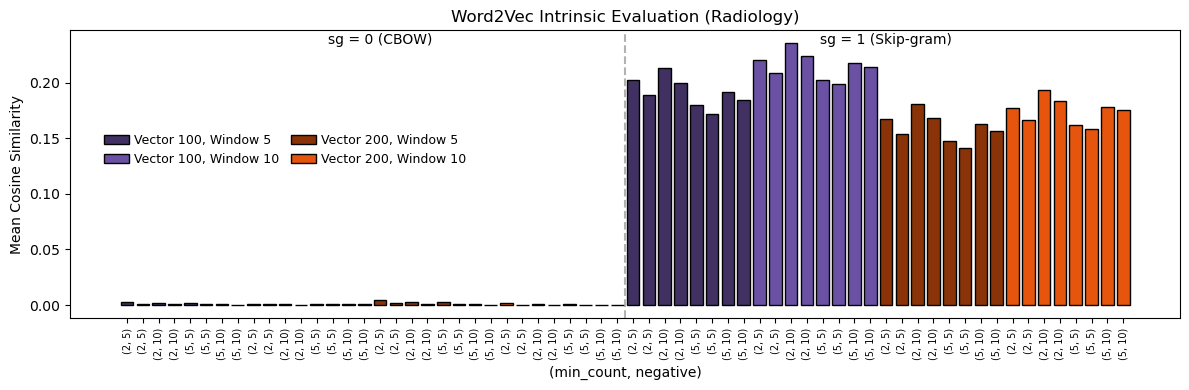

✅ Saved intrinsic evaluation plot to C:\Users\tyler\OneDrive - University of Pittsburgh\BIOST 2021 Thesis\Masters-Thesis\reports\figures\w2v_intrinsic_Radiology.png


In [1]:
# ============================================================
# Recreate Word2Vec Intrinsic Evaluation Plot
# ============================================================

from src.w2v_tuning import plot_intrinsic_results

plot_intrinsic_results("Radiology")


In [9]:
# ============================================================
# Clean export: 6 per-classifier LaTeX tables (rounded, no \table)
# ============================================================
import pandas as pd, ast, os
from src.utils import resolve_path

# ---- Paths
opt_summary_path = resolve_path(
    "results/models/w2v_optimized_radiology/w2v_optimized_radiology_20251027_2357/"
    "w2v_optimized_radiology_20251027_2357_full_summary_with_smote.csv"
)
output_dir = resolve_path("reports/tables/opt_training_params")
output_dir.mkdir(parents=True, exist_ok=True)

# ---- Load & parse params
df = pd.read_csv(opt_summary_path)
df["Best Params"] = df["Best Params"].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) and x.strip().startswith("{") else {}
)

# ---- Format classifier names
name_map = {
    "LogisticRegression": "Logistic Regression",
    "NaiveBayes": "Naïve Bayes",
    "RandomForest": "Random Forest",
    "GradientBoosting": "Gradient Boosting",
    "XGB": "XGBoost",
    "LGBM": "LightGBM",
    "MLP": "Neural Network (MLP)",
    "SVC": "Support Vector Machine",
    "DecisionTree": "Decision Tree",
    "CatBoost": "CatBoost"
}
df["Classifier"] = df["Classifier"].replace(name_map)



# ---- Export each classifier
for _, row in df.iterrows():
    clf = row["Classifier"]
    params = row["Best Params"]
    if not isinstance(params, dict) or not params:
        continue
    if clf == "Random Forest": params["clf__max_features"] = r"$\lfloor \sqrt{143} \rfloor$"

    # build parameter table
    data = []
    for k, v in params.items():
        key = k.replace("clf__", "").replace("_", " ").capitalize()
        if isinstance(v, (float, int)):
            val = f"{float(v):.3f}".rstrip("0").rstrip(".")
        else:
            val = str(v).replace("_", "\\_")
        data.append((key, val))
    clf_df = pd.DataFrame(data, columns=["Parameter", "Value"])

    # export only the tabular body (no \table)
    tex_path = output_dir / f"opt_params_{clf.lower().replace(' ', '_')}.tex"
    latex_str = clf_df.to_latex(index=False, escape=False, column_format="ll")
    latex_str = (
        "\\centering\n"
        + latex_str.replace("\\toprule", "\\hline")
                   .replace("\\midrule", "\\hline")
                   .replace("\\bottomrule", "\\hline")
    )

    with open(tex_path, "w", encoding="utf-8") as f:
        f.write(latex_str)
    print(f"✅ Exported cleaned LaTeX table for {clf} → {tex_path}")


✅ Exported cleaned LaTeX table for Logistic Regression → C:\Users\tyler\OneDrive - University of Pittsburgh\BIOST 2021 Thesis\Masters-Thesis\reports\tables\opt_training_params\opt_params_logistic_regression.tex
✅ Exported cleaned LaTeX table for CatBoost → C:\Users\tyler\OneDrive - University of Pittsburgh\BIOST 2021 Thesis\Masters-Thesis\reports\tables\opt_training_params\opt_params_catboost.tex
✅ Exported cleaned LaTeX table for Gradient Boosting → C:\Users\tyler\OneDrive - University of Pittsburgh\BIOST 2021 Thesis\Masters-Thesis\reports\tables\opt_training_params\opt_params_gradient_boosting.tex
✅ Exported cleaned LaTeX table for XGBoost → C:\Users\tyler\OneDrive - University of Pittsburgh\BIOST 2021 Thesis\Masters-Thesis\reports\tables\opt_training_params\opt_params_xgboost.tex
✅ Exported cleaned LaTeX table for LightGBM → C:\Users\tyler\OneDrive - University of Pittsburgh\BIOST 2021 Thesis\Masters-Thesis\reports\tables\opt_training_params\opt_params_lightgbm.tex
✅ Exported cleane

## Create Extended Results for Optimized W2V Models

In [19]:
# ============================================================
# Rerun Evaluation for Optimized Word2Vec Models (Standalone)
# ============================================================

import pandas as pd
import joblib, os
from src.evaluation import (
    unwrap_best_estimators_non_smote,
    unwrap_best_estimators_smote,
    evaluate_all_models,
    evaluate_classifier_extended
)
from src.utils import resolve_path

# ------------------------------------------------------------
# Paths
# ------------------------------------------------------------
base_eval_dir = resolve_path("results/evaluation/20251108")
os.makedirs(base_eval_dir, exist_ok=True)

model_dir = resolve_path("results/models/w2v_optimized_radiology/w2v_optimized_radiology_20251027_2357")
models_non_smote_path = model_dir / "w2v_optimized_radiology_20251027_2357_full.pkl"
models_smote_path     = model_dir / "w2v_optimized_radiology_20251027_2357_full_smote.pkl"

# ------------------------------------------------------------
# Load datasets (consistent naming)
# ------------------------------------------------------------
X_train_non_smote = pd.read_csv(resolve_path("data/processed/w2v_optimized_radiology/data_w2v_optimized_radiology_xtrain.csv"))
y_train_non_smote = pd.read_csv(resolve_path("data/processed/w2v_optimized_radiology/data_w2v_optimized_radiology_ytrain.csv")).squeeze()
X_test_non_smote  = pd.read_csv(resolve_path("data/processed/w2v_optimized_radiology/data_w2v_optimized_radiology_xtest.csv"))
y_test_non_smote  = pd.read_csv(resolve_path("data/processed/w2v_optimized_radiology/data_w2v_optimized_radiology_ytest.csv")).squeeze()

X_train_smote = pd.read_csv(resolve_path("data/processed/w2v_optimized_radiology/data_w2v_optimized_radiology_xtrain_res.csv"))
y_train_smote = pd.read_csv(resolve_path("data/processed/w2v_optimized_radiology/data_w2v_optimized_radiology_ytrain_res.csv")).squeeze()
X_test_smote  = X_test_non_smote.copy()  # keep same test features
y_test_smote  = y_test_non_smote.copy()  # keep same test labels

# ------------------------------------------------------------
# Load trained models
# ------------------------------------------------------------
models_w2v       = joblib.load(models_non_smote_path)      # full dict w/ CV info
models_w2v_smote = joblib.load(models_smote_path)          # full dict (SMOTE)

# unwrap estimators for evaluation
models_w2v_opt_meta      = models_w2v
models_opt_w2v           = unwrap_best_estimators_non_smote(models_w2v)

models_w2v_opt_meta_smote = models_w2v_smote
models_opt_w2v_smote      = unwrap_best_estimators_smote(models_w2v_smote)

# ------------------------------------------------------------
# Evaluate (Non-SMOTE)
# ------------------------------------------------------------
summary_opt = evaluate_all_models(
    models=models_opt_w2v,
    X_test=X_test_non_smote,
    y_test=y_test_non_smote,
    mode="w2v_optimized_non_smote",
    models_meta=models_w2v_opt_meta
)
display(summary_opt)

extended_opt = []
for name, mdl in models_opt_w2v.items():
    r = evaluate_classifier_extended(
        mdl,
        X_train_non_smote,
        y_train_non_smote,
        X_test_non_smote,
        y_test_non_smote,
        clf_name=name,
        mode="w2v_optimized_non_smote",
        models_meta=models_w2v_opt_meta
    )
    extended_opt.append(r)
df_extended_opt = pd.DataFrame(extended_opt)
df_extended_opt.to_csv(base_eval_dir / "w2v_optimized_extended_summary.csv", index=False)
print("✅ Saved:", base_eval_dir / "w2v_optimized_extended_summary.csv")

# ------------------------------------------------------------
# Evaluate (SMOTE)
# ------------------------------------------------------------
summary_opt_smote = evaluate_all_models(
    models=models_opt_w2v_smote,
    X_test=X_test_smote,
    y_test=y_test_smote,
    mode="w2v_optimized_smote",
    models_meta=models_w2v_opt_meta_smote
)
display(summary_opt_smote)

extended_opt_smote = []
for name, mdl in models_opt_w2v_smote.items():
    r = evaluate_classifier_extended(
        mdl,
        X_train_smote,
        y_train_smote,
        X_test_smote,
        y_test_smote,
        clf_name=name,
        mode="w2v_optimized_smote",
        models_meta=models_w2v_opt_meta_smote
    )
    extended_opt_smote.append(r)
df_extended_opt_smote = pd.DataFrame(extended_opt_smote)
df_extended_opt_smote.to_csv(base_eval_dir / "w2v_optimized_extended_summary_smote.csv", index=False)
print("✅ Saved:", base_eval_dir / "w2v_optimized_extended_summary_smote.csv")


✅ Evaluation summary saved to C:\Users\tyler\OneDrive - University of Pittsburgh\BIOST 2021 Thesis\Masters-Thesis\results\evaluation\20251110\w2v_optimized_non_smote_summary.csv


,Classifier,AUROC,Accuracy,Precision,Recall,F1,Brier,Mean CV AUROC,SD CV AUROC
0,LogisticRegression,0.756984,0.776392,0.550000,0.182573,0.274143,0.152561,0.744873,0.017522
1,RandomForest,0.736077,0.777351,0.909091,0.041494,0.079365,0.158094,0.733171,0.020864
2,GradientBoosting,0.752431,0.775432,0.549296,0.161826,0.250000,0.153832,0.745668,0.019514
3,XGB,0.751043,0.776392,0.560606,0.153527,0.241042,0.161183,0.747944,0.018169
4,LGBM,0.743091,0.777351,0.556962,0.182573,0.275000,0.156884,0.745117,0.019067
5,CatBoost,0.756233,0.783109,0.702703,0.107884,0.187050,0.154544,0.747564,0.017939



📊 LogisticRegression (w2v_optimized_non_smote) → AUC_test=0.7570, Brier_test=0.1526, CV_mean=0.7449, CV_std=0.0175

📊 RandomForest (w2v_optimized_non_smote) → AUC_test=0.7361, Brier_test=0.1581, CV_mean=0.7332, CV_std=0.0209

📊 GradientBoosting (w2v_optimized_non_smote) → AUC_test=0.7524, Brier_test=0.1538, CV_mean=0.7457, CV_std=0.0195

📊 XGB (w2v_optimized_non_smote) → AUC_test=0.7510, Brier_test=0.1612, CV_mean=0.7479, CV_std=0.0182

📊 LGBM (w2v_optimized_non_smote) → AUC_test=0.7431, Brier_test=0.1569, CV_mean=0.7451, CV_std=0.0191

📊 CatBoost (w2v_optimized_non_smote) → AUC_test=0.7562, Brier_test=0.1545, CV_mean=0.7476, CV_std=0.0179
✅ Saved: C:\Users\tyler\OneDrive - University of Pittsburgh\BIOST 2021 Thesis\Masters-Thesis\results\evaluation\20251108\w2v_optimized_extended_summary.csv
✅ Evaluation summary saved to C:\Users\tyler\OneDrive - University of Pittsburgh\BIOST 2021 Thesis\Masters-Thesis\results\evaluation\20251110\w2v_optimized_smote_summary.csv


,Classifier,AUROC,Accuracy,Precision,Recall,F1,Brier,Mean CV AUROC,SD CV AUROC
0,LogisticRegression,0.753001,0.681382,0.393443,0.697095,0.502994,0.203107,0.779196,0.010562
1,RandomForest,0.737056,0.778311,0.547170,0.240664,0.334294,0.164043,0.948071,0.007696
2,GradientBoosting,0.734248,0.757198,0.460000,0.286307,0.352941,0.160678,0.934694,0.007763
3,XGB,0.751643,0.770633,0.509615,0.219917,0.307246,0.160621,0.944487,0.008069
4,LGBM,0.750701,0.781190,0.554622,0.273859,0.366667,0.156441,0.938894,0.006682
5,CatBoost,0.736325,0.779271,0.551402,0.244813,0.339080,0.157353,0.944496,0.005823



📊 LogisticRegression (w2v_optimized_smote) → AUC_test=0.7530, Brier_test=0.2031, CV_mean=0.7792, CV_std=0.0106

📊 RandomForest (w2v_optimized_smote) → AUC_test=0.7371, Brier_test=0.1640, CV_mean=0.9481, CV_std=0.0077

📊 GradientBoosting (w2v_optimized_smote) → AUC_test=0.7342, Brier_test=0.1607, CV_mean=0.9347, CV_std=0.0078

📊 XGB (w2v_optimized_smote) → AUC_test=0.7516, Brier_test=0.1606, CV_mean=0.9445, CV_std=0.0081

📊 LGBM (w2v_optimized_smote) → AUC_test=0.7507, Brier_test=0.1564, CV_mean=0.9389, CV_std=0.0067

📊 CatBoost (w2v_optimized_smote) → AUC_test=0.7363, Brier_test=0.1574, CV_mean=0.9445, CV_std=0.0058
✅ Saved: C:\Users\tyler\OneDrive - University of Pittsburgh\BIOST 2021 Thesis\Masters-Thesis\results\evaluation\20251108\w2v_optimized_extended_summary_smote.csv


## Clustering at the word level (semantic structure of the vocabulary)

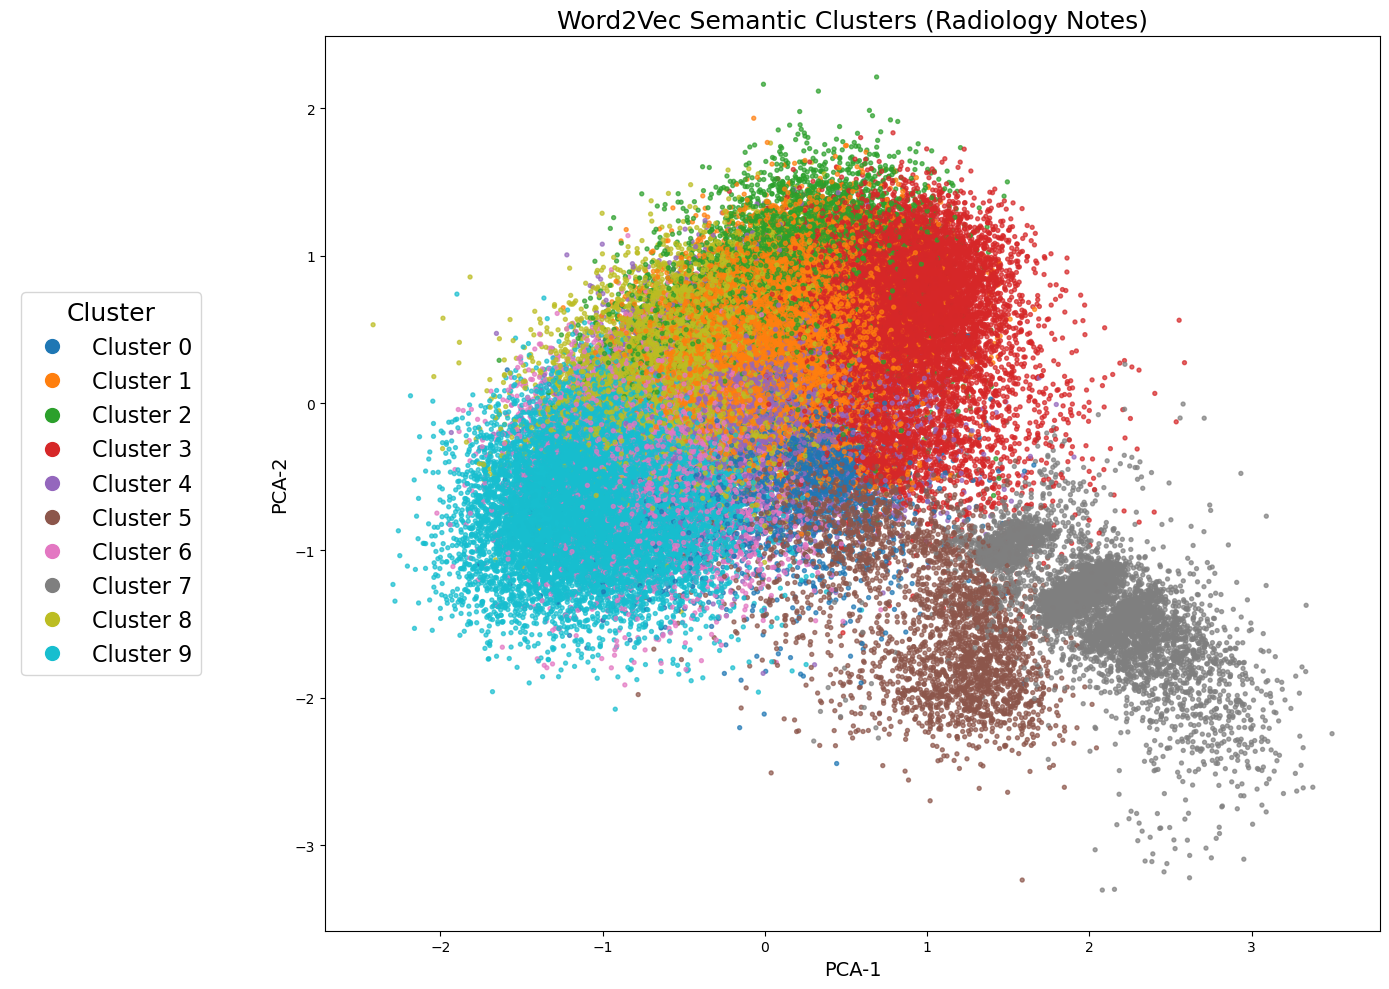

Saved figure to: C:\Users\tyler\OneDrive - University of Pittsburgh\BIOST 2021 Thesis\Masters-Thesis\results\figures\w2v_optimized_radiology\w2v_radiology_clusters.png
Saved cluster CSV to: C:\Users\tyler\OneDrive - University of Pittsburgh\BIOST 2021 Thesis\Masters-Thesis\results\figures\w2v_optimized_radiology\w2v_radiology_clusters.csv


In [1]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from gensim.models import Word2Vec
import pandas as pd
from pathlib import Path
from src.utils import resolve_path

# ================================
# Load trained Word2Vec model
# ================================
model_path = resolve_path("embedding_cache/w2v/tuned/Radiology/best_Radiology_w2v.model")
w2v_model = Word2Vec.load(str(model_path))

# ================================
# Extract word vectors
# ================================
words = list(w2v_model.wv.index_to_key)
vectors = w2v_model.wv[words]

# ================================
# KMeans clustering
# ================================
kmeans = KMeans(n_clusters=10, random_state=42)
clusters = kmeans.fit_predict(vectors)

word_clusters = pd.DataFrame({"word": words, "cluster": clusters})

# ================================
# PCA for visualization
# ================================
pca = PCA(n_components=2, random_state=42)
coords = pca.fit_transform(vectors)
word_clusters["x"], word_clusters["y"] = coords[:, 0], coords[:, 1]

# ================================
# Save directory
# ================================
out_dir = Path(resolve_path("results/figures/w2v_optimized_radiology/"))
out_dir.mkdir(parents=True, exist_ok=True)

fig_path = out_dir / "w2v_radiology_clusters.png"
csv_path = out_dir / "w2v_radiology_clusters.csv"

# ================================
# Plot with manual legend axis
# ================================
plt.figure(figsize=(14, 10))

# Create GridSpec: left column = legend, right = plot
gs = plt.GridSpec(1, 2, width_ratios=[0.18, 0.82])
ax_legend = plt.subplot(gs[0])
ax = plt.subplot(gs[1])

# Turn off legend axis frame
ax_legend.axis("off")

# Scatterplot
palette = sns.color_palette("tab10", 10)
scatter = ax.scatter(
    word_clusters["x"],
    word_clusters["y"],
    c=word_clusters["cluster"].map(dict(zip(range(10), palette))),
    s=8,
    alpha=0.7
)

ax.set_title("Word2Vec Semantic Clusters (Radiology Notes)", fontsize=18)
ax.set_xlabel("PCA-1", fontsize=14)
ax.set_ylabel("PCA-2", fontsize=14)

# ======================================
# MANUAL LEGEND — guaranteed to work
# ======================================
handles = [
    plt.Line2D([0], [0], marker="o", color="w",
               markerfacecolor=palette[i], markersize=12)
    for i in range(10)
]
labels = [f"Cluster {i}" for i in range(10)]

ax_legend.legend(
    handles, labels,
    title="Cluster",
    loc="center left",
    fontsize=16,
    title_fontsize=18,
    frameon=True,
)

plt.tight_layout()

plt.savefig(fig_path, dpi=300, bbox_inches="tight")
plt.show()

# Save metadata
word_clusters.to_csv(csv_path, index=False)
print(f"Saved figure to: {fig_path}")
print(f"Saved cluster CSV to: {csv_path}")


## Clustering at the patient level (feature pattern clusters)

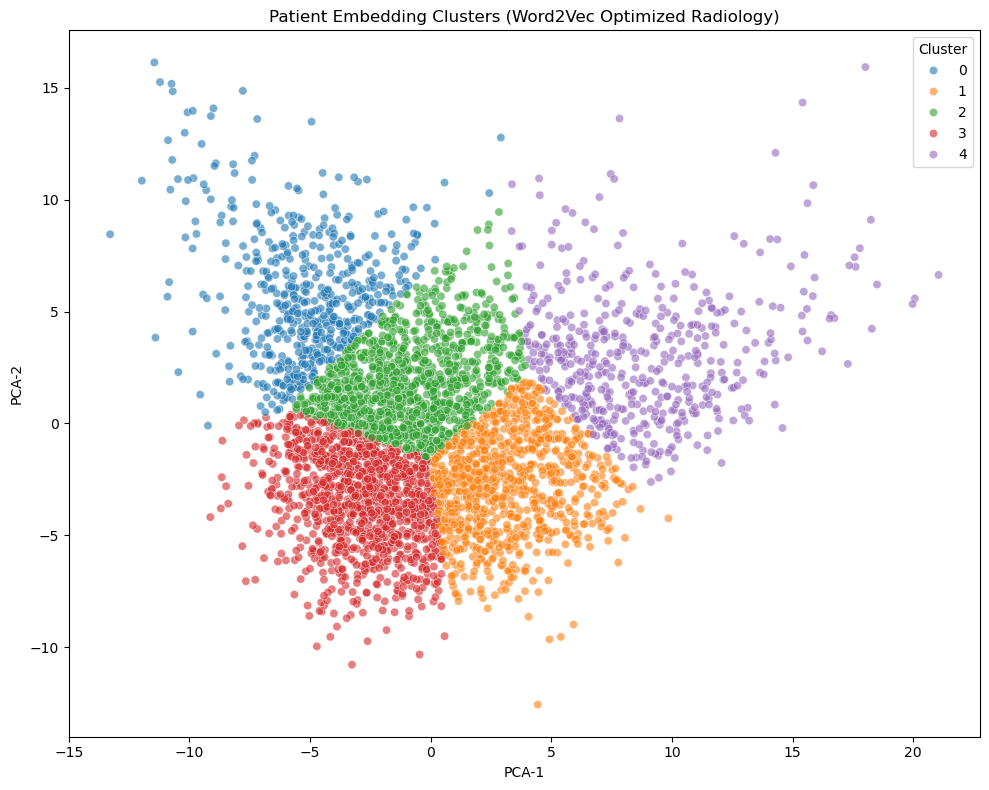

hospital_expire_flag    0    1
row_0                         
0                     386  143
1                     713  178
2                     790  311
3                     930  230
4                     385  100


In [37]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Load patient-level embeddings
X = pd.read_csv(resolve_path("data/processed/w2v_optimized_radiology/data_w2v_optimized_radiology_xtrain.csv"))
y = pd.read_csv(resolve_path("data/processed/w2v_optimized_radiology/data_w2v_optimized_radiology_ytrain.csv")).squeeze()

# Extract only W2V dimensions
w2v_cols = [c for c in X.columns if c.startswith("w2v_opt_rad_")]
X_w2v = X[w2v_cols]

# Standardize
X_scaled = StandardScaler().fit_transform(X_w2v)

# Reduce to 2D for visualization
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# Cluster in 2D space
kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(X_pca)

# Plot clusters
plt.figure(figsize=(10, 8))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=clusters, palette="tab10", alpha=0.6)
plt.title("Patient Embedding Clusters (Word2Vec Optimized Radiology)")
plt.xlabel("PCA-1")
plt.ylabel("PCA-2")
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()

# Optional: check class balance in each cluster
cluster_summary = pd.crosstab(clusters, y)
print(cluster_summary)


## Best Models Comparisons across Resampling Schemes